## Thêm thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
from scipy.stats import norm


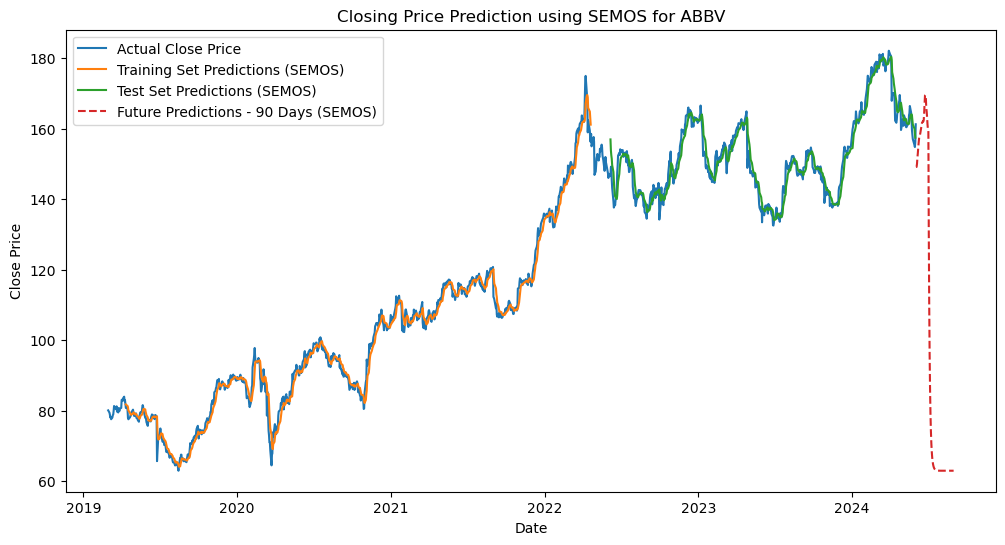

In [2]:
# Load the data
df = pd.read_csv('ABBV-AbbVie.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Create a new DataFrame with Date and Close columns
df_close = pd.DataFrame(df, columns=['Close'])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_scaled = scaler.fit_transform(df_close)

# Split the data into training and test sets
train_size = int(len(df_close_scaled) * 0.6)
test_size = len(df_close_scaled) - train_size
train_data = df_close_scaled[:train_size]
test_data = df_close_scaled[train_size:]

# Function to create dataset for SEMOS
def create_dataset_semos(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step for SEMOS model
time_step = 30
X_train_semos, y_train_semos = create_dataset_semos(train_data, time_step)
X_test_semos, y_test_semos = create_dataset_semos(test_data, time_step)

# Apply SEMOS
def semos_predict(train, test, alpha=0.3):
    predictions = []
    smoothed_value = train[0]  # Initialize with the first value
    for value in np.concatenate((train, test)):
        smoothed_value = alpha * value + (1 - alpha) * smoothed_value
        predictions.append(smoothed_value)
    return predictions

# Predict on training and test data
train_predict_semos = semos_predict(X_train_semos[:, -1], X_test_semos[:, -1])

# Inverse transform the predictions
train_predict_semos = scaler.inverse_transform(np.array(train_predict_semos).reshape(-1, 1))

# Prepare data for plotting
train_predict_plot_semos = np.empty_like(df_close_scaled)
train_predict_plot_semos[:, :] = np.nan
train_predict_plot_semos[time_step:len(y_train_semos) + time_step, :] = train_predict_semos[:len(y_train_semos)]

test_predict_plot_semos = np.empty_like(df_close_scaled)
test_predict_plot_semos[:, :] = np.nan
test_predict_plot_semos[len(y_train_semos) + (time_step * 2) + 1:len(df_close_scaled) - 1, :] = train_predict_semos[len(y_train_semos):]

# Extend predictions for the next 90 days using SEMOS
future_time_steps = 90

# Reshape train_data[-1:] to have the same shape as test_data
train_last = train_data[-time_step:].reshape(1, -1)  # reshape to (1, time_step)

# Create an array of zeros for future predictions
future_zeros = np.zeros((future_time_steps, 1))  # shape: (future_time_steps, 1)

# Predict for the next 90 days
future_predictions = semos_predict(train_last[0], future_zeros[:, 0], alpha=0.3)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare data for plotting future predictions
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_time_steps, freq='D')

# Adjust size to include predictions for the next 90 days
future_predict_plot_semos_extended = np.empty((len(df_close_scaled) + future_time_steps, 1))
future_predict_plot_semos_extended[:, :] = np.nan
future_predict_plot_semos_extended[:len(df_close_scaled), :] = scaler.inverse_transform(df_close_scaled)
future_predict_plot_semos_extended[len(df_close_scaled):len(df_close_scaled) + future_time_steps, :] = future_predictions[:future_time_steps]  # Adjusted assignment

# Plot the data including future predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df_close_scaled), label='Actual Close Price')
plt.plot(df.index[time_step:len(y_train_semos) + time_step], train_predict_plot_semos[time_step:len(y_train_semos) + time_step], label='Training Set Predictions (SEMOS)')
plt.plot(df.index[len(y_train_semos) + (time_step * 2) + 1:len(df_close_scaled)], test_predict_plot_semos[len(y_train_semos) + (time_step * 2) + 1:len(df_close_scaled)], label='Test Set Predictions (SEMOS)')
plt.plot(future_index, future_predict_plot_semos_extended[len(df_close_scaled):len(df_close_scaled) + future_time_steps, :], label='Future Predictions - 90 Days (SEMOS)', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('Closing Price Prediction using SEMOS for ABBV')
plt.show()
